Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.xception import Xception, preprocess_input
from keras.layers import Dense, MaxPool2D, Conv2D, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

import matplotlib.image as mpimg


In [2]:
tf.__version__

'2.9.1'

## 1. Data Reading/Data Understanding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
fp_train="Train"
fp_test="Test"

In [4]:
# Defining the path for train and test images
img_dir_train = pathlib.Path(fp_train)
img_dir_test = pathlib.Path(fp_test)

In [5]:
total_train_imgs = len(list(img_dir_train.glob('*/*.jpg')))
print("total_train_imgs ",total_train_imgs)
total_test_imgs = len(list(img_dir_test.glob('*/*.jpg')))
print("total_test_imgs ",total_test_imgs)

total_train_imgs  2239
total_test_imgs  118


## 2. Dataset creation

In [6]:
# batch_size 
bs = 32

# img_height 
ih = 180

# img_width 
iw= 180

# num_classes
nc = 9

Use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(ih,iw),
    batch_size = bs
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    img_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(ih,iw),
    batch_size = bs
) 

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
all_classes = train_ds.class_names
print(all_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3. Dataset visualisation
**Created a code to visualize one instance of all the nine classes present in the dataset**

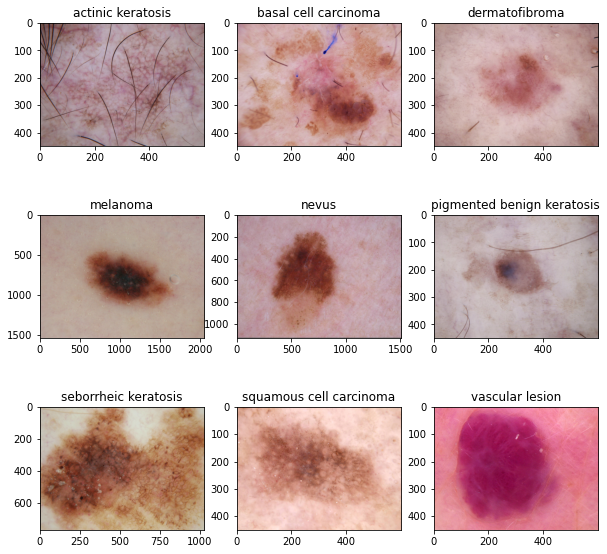

In [10]:
plt.figure(figsize=(10,10))
for i in range(9): 
    plt.subplot(3, 3, i + 1)
    each_class = mpimg.imread(str(list(img_dir_train.glob(all_classes[i]+'/*.jpg'))[1]))
    plt.title(all_classes[i])
    plt.imshow(each_class)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Model Building & training

* Created a CNN model, which can accurately detect 9 classes present in the dataset.
* Defined appropriate optimiser and loss function for model training.
* Trained the model for ~20 epochs.
* Explained the findings after the model fit with evidence if the earlier issue is resolved or not.

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling,RandomFlip,RandomRotation,RandomZoom

In [13]:
mod1 = Sequential([
                    Rescaling(1./255, input_shape=(ih, iw,3))
])

# L1
mod1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (ih, iw, 32)))
# L2
mod1.add(Conv2D(32, (5, 5)))
mod1.add(Activation('relu'))
mod1.add(MaxPooling2D(pool_size=(2, 2)))
# L3
mod1.add(Conv2D(32, (5, 5)))
mod1.add(Activation('relu'))
mod1.add(MaxPooling2D(pool_size=(2, 2)))
# L4
mod1.add(Conv2D(32, (5, 5)))
mod1.add(Activation('relu'))
mod1.add(MaxPooling2D(pool_size=(2, 2)))
mod1.add(Dropout(0.5))

# L5
mod1.add(Flatten())
mod1.add(Dense(nc))
mod1.add(Activation('softmax'))

### 4.1. Compile the model
**As it is a multi class classification, we are using SparseCategoricalCrossEntropy as the loss function, and we are using adam optimizer as a hit & trial, further we can perform hyper parameter optimization and change the optimizer accordingly**

In [14]:
mod1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
mod1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      25632     
                                                                 
 activation (Activation)     (None, 176, 176, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 32)        25632     
                                                        

### 4.2. Train the model

In [16]:
epochs = 20
hist1 = mod1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


C:\Users\Yash Gupta\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 174s 3s/step - loss: 2.0399 - accuracy: 0.1836 - val_loss: 1.9182 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 159s 3s/step - loss: 1.8691 - accuracy: 0.3125 - val_loss: 2.0542 - val_accuracy: 0.2170
Epoch 3/20
56/56 [==============================] - 159s 3s/step - loss: 1.8324 - accuracy: 0.3153 - val_loss: 1.8146 - val_accuracy: 0.3177
Epoch 4/20
56/56 [==============================] - 153s 3s/step - loss: 1.6684 - accuracy: 0.3984 - val_loss: 1.6402 - val_accuracy: 0.4161
Epoch 5/20
56/56 [==============================] - 159s 3s/step - loss: 1.5803 - accuracy: 0.4241 - val_loss: 1.7998 - val_accuracy: 0.3915
Epoch 6/20
56/56 [==============================] - 155s 3s/step - loss: 1.6129 - accuracy: 0.4113 - val_loss: 1.7504 - val_accuracy: 0.3311
Epoch 7/20
56/56 [==============================] - 156s 3s/step - loss: 1.5573 - accuracy: 0.4342 - val_loss: 1.6030 - val_accuracy: 0.4362
Epoch 8/20
56/56 [======

### Visualizing training results

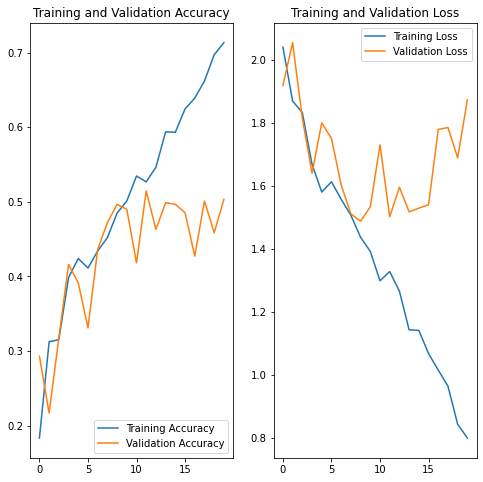

In [17]:
acc = hist1.history['accuracy']
val_acc = hist1.history['val_accuracy']

loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

# epochs_range
er = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(er, acc, label='Training Accuracy')
plt.plot(er, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(er, loss, label='Training Loss')
plt.plot(er, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings on the first base model


*   Initial findings: The model is overfitting because overfitting is calculated w.r.t loss, and we can also see difference in loss functions in training & test around the 19-20th epoch 
*   The accuracy is low because there are enough features to remember the pattern, and the neural network is very young (just 20 epochs), so the learning has just started

In [18]:
# !pip install pyyaml h5py

In [19]:
# mod1.save('model_1.h5')

## 5. Data augmentation

**Chose an appropriate data augmentation strategy to resolve underfitting/overfitting**

In [20]:
img_gen_keras = Sequential([RandomFlip(mode="horizontal_and_vertical",input_shape=(ih,iw,3)),
                       RandomRotation(0.2, fill_mode='reflect'),
                       RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

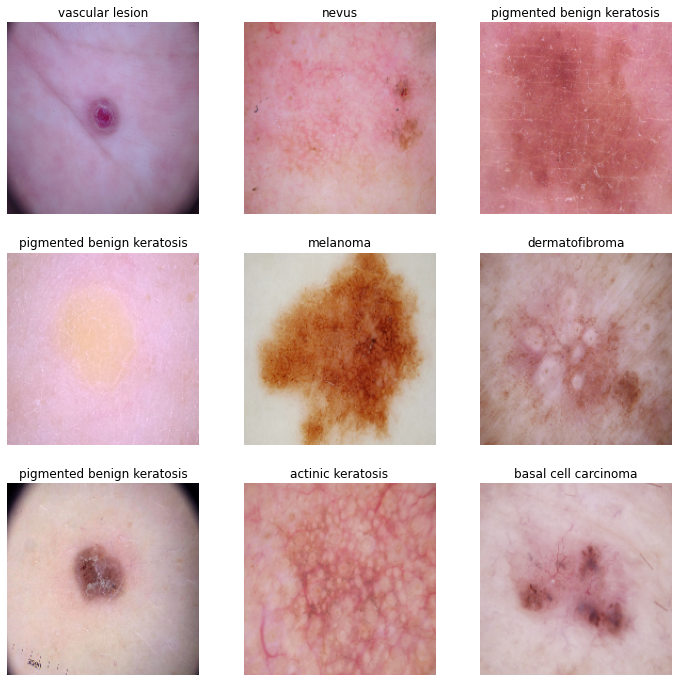

In [21]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img_gen_keras(images)[i].numpy().astype("uint8"))
        plt.title(all_classes[labels[i]])
        plt.axis("off")

### 5.1. Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
mod2 = Sequential([img_gen_keras,
                    Rescaling(1./255, input_shape=(ih, iw,3))
])

# L1
mod2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
# L2
mod2.add(Conv2D(32, (5, 5)))
mod2.add(Activation('relu'))
mod2.add(MaxPooling2D(pool_size=(2, 2)))
# L3
mod2.add(Conv2D(32, (5, 5)))
mod2.add(Activation('relu'))
mod2.add(MaxPooling2D(pool_size=(2, 2)))
# L4
mod2.add(Conv2D(32, (5, 5)))
mod2.add(Activation('relu'))
mod2.add(MaxPooling2D(pool_size=(2, 2)))
mod2.add(Dropout(0.5))

# L5
mod2.add(Flatten())
mod2.add(Dense(nc))
mod2.add(Activation('softmax'))



### 5.2. Compiling the model

In [23]:
mod2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 5.3. Training the model

In [24]:
epochs = 20
hist2 = mod2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 171s 3s/step - loss: 2.0583 - accuracy: 0.2026 - val_loss: 2.0258 - val_accuracy: 0.2036
Epoch 2/20
56/56 [==============================] - 176s 3s/step - loss: 1.9945 - accuracy: 0.2533 - val_loss: 1.9236 - val_accuracy: 0.2662
Epoch 3/20
56/56 [==============================] - 177s 3s/step - loss: 1.8452 - accuracy: 0.3019 - val_loss: 1.8194 - val_accuracy: 0.2886
Epoch 4/20
56/56 [==============================] - 159s 3s/step - loss: 1.7551 - accuracy: 0.3599 - val_loss: 1.6697 - val_accuracy: 0.4027
Epoch 5/20
56/56 [==============================] - 154s 3s/step - loss: 1.7116 - accuracy: 0.3722 - val_loss: 1.6735 - val_accuracy: 0.4139
Epoch 6/20
56/56 [==============================] - 154s 3s/step - loss: 1.6221 - accuracy: 0.4135 - val_loss: 1.5897 - val_accuracy: 0.4049
Epoch 7/20
56/56 [==============================] - 154s 3s/step - loss: 1.5808 - accuracy: 0.4330 - val_loss: 1.5837 - val_accuracy: 0.4519
Epoch 8/20
56

### 5.4. Visualizing the results

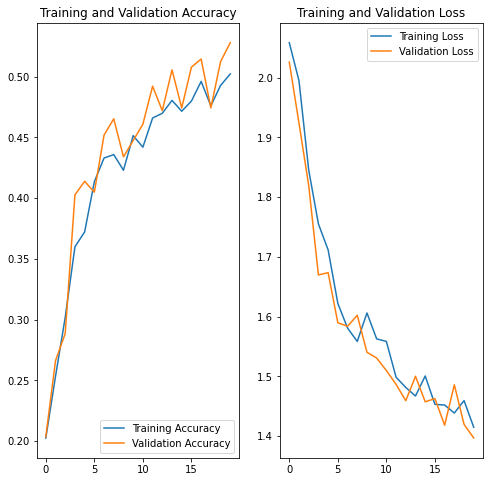

In [25]:
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']

loss = hist2.history['loss']
val_loss = hist2.history['val_loss']

# epochs_range
er = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(er, acc, label='Training Accuracy')
plt.plot(er, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(er, loss, label='Training Loss')
plt.plot(er, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings:


* We can see with data augmentation overfitting issue has *faded away*
* Although accuracy didnt increase much as compared to base model

In [26]:
# mod2.save('model_2.h5')

## 6. Class distribution	

Examined the current class distribution in the training dataset & explained the following:
* Which class has the least number of samples?
* Which classes dominate the data in terms of the proportionate number of samples?

In [27]:
img_paths=[]
all_labels=[]
for i in all_classes:
      
    for j in img_dir_train.glob(i+'/*.jpg'):
        img_paths.append(str(j))
        all_labels.append(i)
pathToLabelMap = dict(zip(img_paths, all_labels))
actual_df = pd.DataFrame(list(pathToLabelMap.items()),columns = ['Path','Label'])
actual_df

,Path,Label
0,Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis
...,...,...
2234,Train\vascular lesion\ISIC_0033844.jpg,vascular lesion
2235,Train\vascular lesion\ISIC_0033969.jpg,vascular lesion
2236,Train\vascular lesion\ISIC_0033991.jpg,vascular lesion
2237,Train\vascular lesion\ISIC_0034196.jpg,vascular lesion


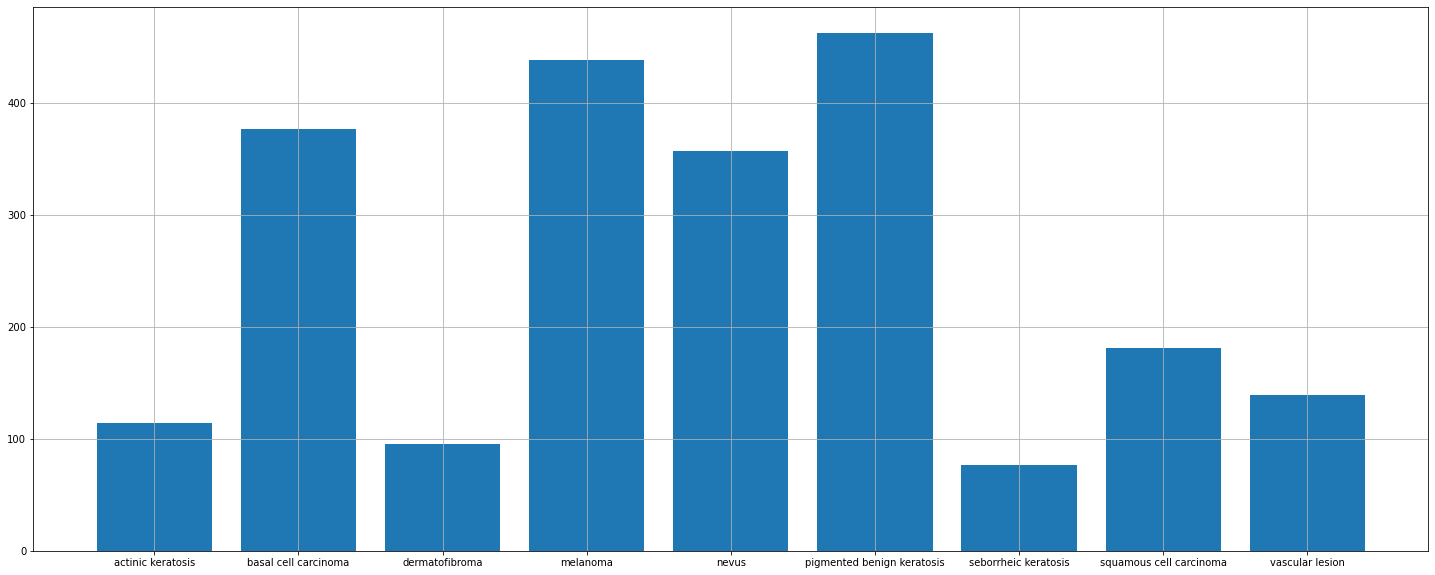

In [28]:
count=[]
for i in all_classes:
    count.append(len(list(img_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(all_classes,count)
plt.grid()

#### Findings : 
#### - Seborrheic keratosis has least number of samples
#### - Pigmented benign keratosis dominates other classes in case of number of samples


##  7. Handling class imbalances
**Rectified class imbalances present in the training dataset with Augmentor library**

In [29]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
import Augmentor

fp_train=fp_train+'/'
fp_train
path_to_training_dataset=fp_train
batch_size = 128

In [31]:
img_aug=Augmentor.Pipeline(path_to_training_dataset)

Initialised with 2239 image(s) found.
Output directory set to Train/output.

* rotate : The probability parameter controls how often the operation is applied. The max_left_rotation and max_right_rotation controls the degree by which the image is rotated, if the operation is applied. The value, in this case between -5 and 10 degrees, is chosen at random.

In [32]:
# img_aug.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)

# img_aug.flip_random(probability=0.5)

# img_aug.random_distortion(probability=0.8,grid_height=16,grid_width=16,magnitude=8)

# # img_aug.zoom(probability=0.3,min_factor=1.1,max_factor=1.6)

In [33]:
img_aug.rotate(probability=0.2, max_left_rotation=2, max_right_rotation=2)
img_aug.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
img_aug.skew(probability=0.2)
img_aug.random_distortion(probability=0.2, grid_width=100, grid_height=100, magnitude=1)
img_aug.shear(probability=0.2, max_shear_left=2, max_shear_right=2)
img_aug.flip_random(probability=0.2)

In [34]:
img_aug.sample(4500)

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D2D9AB26A0>: 100%|█| 4500/4500 [09:19<00:00,  8.04 Sample


In [35]:
# Folder that contains Augmented Images dataset
aug_dir_train='Train/output'
aug_dir_train

'Train/output'

## 8. Model Building & training (augmented)

### 8.1. Create a training and validation dataset

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  aug_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(ih, iw),
  batch_size=bs)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  aug_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(ih, iw),
  batch_size=bs)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


### 8.2. Creating Model

In [38]:
mod3 = Sequential([Rescaling(1./255, input_shape=(ih, iw,3))])

# L1
mod3.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
# L2
mod3.add(Conv2D(32, (5, 5)))
mod3.add(Activation('relu'))
mod3.add(MaxPooling2D(pool_size=(2, 2)))
# L3
mod3.add(Conv2D(32, (5, 5)))
mod3.add(Activation('relu'))
mod3.add(MaxPooling2D(pool_size=(2, 2)))
# L4
mod3.add(Conv2D(32, (5, 5)))
mod3.add(Activation('relu'))
mod3.add(MaxPooling2D(pool_size=(2, 2)))
mod3.add(Dropout(0.5))

# L5
mod3.add(Flatten())
mod3.add(Dense(nc))
mod3.add(Activation('softmax'))



### 8.3. Compile your model

In [39]:
mod3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 8.4. Train your model

In [40]:
epochs = 30
hist3 = mod3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


C:\Users\Yash Gupta\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


113/113 [==============================] - 422s 4s/step - loss: 2.0255 - accuracy: 0.2097 - val_loss: 1.9138 - val_accuracy: 0.2089
Epoch 2/30
113/113 [==============================] - 420s 4s/step - loss: 1.8630 - accuracy: 0.2861 - val_loss: 1.9599 - val_accuracy: 0.2533
Epoch 3/30
113/113 [==============================] - 426s 4s/step - loss: 1.7342 - accuracy: 0.3322 - val_loss: 2.1889 - val_accuracy: 0.3211
Epoch 4/30
113/113 [==============================] - 421s 4s/step - loss: 1.6589 - accuracy: 0.3864 - val_loss: 1.5934 - val_accuracy: 0.4322
Epoch 5/30
113/113 [==============================] - 422s 4s/step - loss: 1.5749 - accuracy: 0.4247 - val_loss: 1.5788 - val_accuracy: 0.4244
Epoch 6/30
113/113 [==============================] - 424s 4s/step - loss: 1.4644 - accuracy: 0.4678 - val_loss: 1.5519 - val_accuracy: 0.4678
Epoch 7/30
113/113 [==============================] - 422s 4s/step - loss: 1.4533 - accuracy: 0.4764 - val_loss: 1.4388 - val_accuracy: 0.5100
Epoch 8/30

### 8.5. Visualize the model results

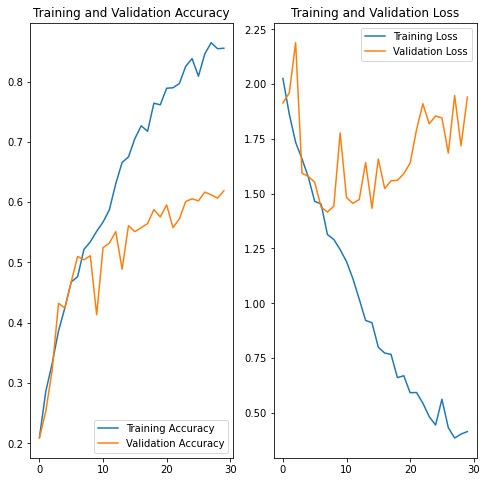

In [41]:
acc = hist3.history['accuracy']
val_acc = hist3.history['val_accuracy']

loss = hist3.history['loss']
val_loss = hist3.history['val_loss']

# epochs_range
er = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(er, acc, label='Training Accuracy')
plt.plot(er, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(er, loss, label='Training Loss')
plt.plot(er, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
# mod3.save('model_3.h5')

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



* Using Augmentor library improved the accuracy of model
* But it failed to get rid of overfitting